<a href="https://colab.research.google.com/github/Bryan-Az/Unsloth_LLM_Tools/blob/main/supplemented_chat/unsloth_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Unsloth to Create a Text Classification Model
Such a model is useful for understanding text that is used as input to a conversational model. For example, in the case of the notebook provided by Unsloth for text classification in their documentation - it is used to classify the sentiment of tweets. In this notebook, I'll be classifying code using a coder model. I recommend running this notebook using the A100 google colab environment.

## Imports and Installs

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth
# Get latest Unsloth
!pip install --upgrade --force-reinstall --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [2]:
# needed as this function doesn't like it when the lm_head has its size changed
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [3]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Major: 8, Minor: 0


## Loading the Backbone Model Architecture
I'll be using my continue pretrained and finetuned Qwen 2.5 'Coder' model for a code classification task.

In [4]:
# os.environ["WANDB_DISABLED"] = "true"

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+


# model_name = "unsloth/Qwen2-7B-bnb-4bit";load_in_4bit = True
model_name = "Alexis-Az/Qwen-2.5-Coder-7B-CSharp-Alpaca-Code-ORPO-LoRA";load_in_4bit = True,

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

==((====))==  Unsloth 2024.9.post4: Fast Qwen2 patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.87k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/162M [00:00<?, ?B/s]

Unsloth 2024.9.post4 patched 28 layers with 0 QKV layers, 28 O layers and 28 MLP layers.


In [5]:
# adding tokens to the model for binary classification
yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("No", add_special_tokens=False)[0]
# keep only the yes and no tokens from lm_head
par = torch.nn.Parameter(torch.vstack([model.lm_head.weight[no_token_id, :], model.lm_head.weight[yes_token_id, :]]))
print(par.shape)
print(model.lm_head.weight.shape)
model.lm_head.weight = par

torch.Size([2, 3584])
torch.Size([152064, 3584])


## Loading the Dataset

In [6]:
# prompt: load the codeparrot/github-code and import the huggingface load_dataset library using streaming to do it as it is massive and unable to be loaded fully. Also sample the dataset to have only 1000 rows for both training and validation and have them loaded as a pandas dataset

# Load the dataset using streaming
dataset = load_dataset("codeparrot/github-code", streaming=True)

# Sample the dataset (1000 rows each for train and validation)
train_dataset = dataset['train'].take(1000)
val_dataset = dataset['train'].skip(1000).take(1000)

# Convert to pandas DataFrames
train_df = pd.DataFrame(list(train_dataset))
val_df = pd.DataFrame(list(val_dataset))

print(f"Training dataset shape: {train_df.shape}")
print(f"Validation dataset shape: {val_df.shape}")


github-code.py:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.54k [00:00<?, ?B/s]

The repository for codeparrot/github-code contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/codeparrot/github-code.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Training dataset shape: (1000, 6)
Validation dataset shape: (1000, 6)


### Visualizing the Token Counts of the Dataset's Code Column
As code is unlike natural language, visualizing the number of tokens may give insight into the complexity of the data. It appears from the plot that the dataset has a massive amount of tokens - way more than was in the tweet sentiment dataset shown in the Unsloth documentation.

In [7]:
train_df.sample(5)

code  \
887  #ifdef __OBJC__\n#import <UIKit/UIKit.h>\n#els...   
173  <?php\r\n/**\r\n * wm.class.php - window manag...   
367  /**\n * React Starter Kit (https://www.reactst...   
327  <a alt="joel 1" href="#/web/joel/1"><div class...   
136  ﻿#region License\n\n// Distributed under the M...   

                           repo_name  \
887             flow-ai/flowai-swift   
173                callicore/library   
367  hmeinertrita/MyPlanetGirlGuides   
327              barryanders/ezra.js   
136            HotcakesCommerce/core   

                                                  path    language license  \
887  Example/Pods/Target Support Files/FlowCore/Flo...           C     mit   
173                               lib/lib/wm.class.php         PHP     mit   
367                        src/routes/search/Search.js  JavaScript     mit   
327                 content/bibles/web/joel/index.html        HTML     mit   
136  Libraries/Hotcakes.Commerce.Dnn/DnnConfigurati...          C#     mit   

     size  
887   308  
173  4546  
367  1083  
327   216  
136  2605

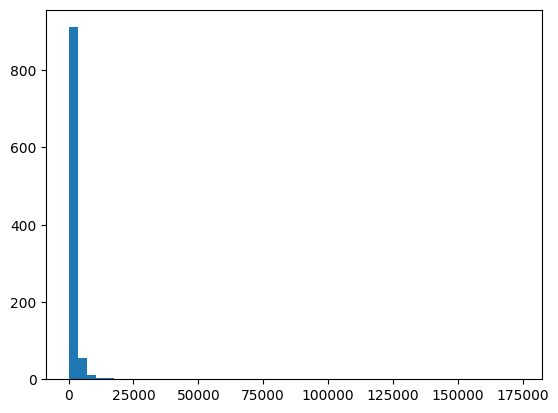

In [8]:
token_counts = [len(tokenizer.encode(x)) for x in train_df.code]
# plot the token counts
a = plt.hist(token_counts, bins=50)

## Formatting the Dataset to the Training Prompt

In [9]:
# converting the pandas dataset to the huggingface dataset
train_dataset = datasets.Dataset.from_pandas(train_df,preserve_index=False)
train_dataset

Dataset({
    features: ['code', 'repo_name', 'path', 'language', 'license', 'size'],
    num_rows: 1000
})

In [10]:
prompt = """This is a sample of code taken from Github:
{}

Is this code written in C? Answer with "Yes" or "No".

SOLUTION
The code is written in: "{}"""

positivelabel = "Yes"
negativelabel = "No"


def formatting_prompts_func(dataset_):
    # this is to fix an issue with a certain transformers version, you might not need this
    if isinstance(dataset_['code'], str):
        if model_name.lower().__contains__("qwen"):
            return [""]*100
        elif model_name.lower().__contains__("llama"):
            return " "
        else:
            return " "

    texts = []
    for i in range(len(dataset_['code'])):
        t = dataset_['code'][i]
        label = positivelabel if dataset_['language'][i] == 'C' else negativelabel
        text = prompt.format(t, label)


        texts.append(text)
    return texts

In [11]:
# this custom collator is needed to change the sequence labels from yes_token_id and no_token_id to 1 and 0. It also trains only on the last token of the sequence.
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Find the last non-padding token
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            # Set all labels to ignore_index except for the last token
            batch["labels"][i, :last_token_idx] = self.ignore_index
            # The old labels for the Yes and No tokens need to be mapped to 1 and 0
            batch["labels"][i, last_token_idx] = 1 if batch["labels"][i, last_token_idx] == yes_token_id else 0


        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

## Training the Model to Classify whether Code is written in C

In [12]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # not needed because group_by_length is True
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        # report_to = "wandb",
        report_to = "none",
        group_by_length = True,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 32
 "-____-"     Number of trainable parameters = 40,377,344


## Uploading the Trained Model to HuggingFace

In [15]:
from google.colab import userdata

In [16]:
model.push_to_hub("Alexis-Az/Qwen-2.5-Coder-7B-CSharp-Alpaca-Code-ORPO-LoRA", tokenizer, token = userdata.get('HF_TOKEN'))

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/162M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Alexis-Az/Qwen-2.5-Coder-7B-CSharp-Alpaca-Code-ORPO-LoRA


## Inferring using the Model on a Data Sample

To infer using Unsloth, the model needs to be modified using the .for_inference and .save_pretrained methods.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [18]:
saved_name = f"lora_model_{model_name.replace('/','_')}"
model.save_pretrained(saved_name)

In [21]:
from collections import defaultdict
import torch.nn.functional as F

# Step 1: Tokenize the inputs and sort them by their tokenized length
tokenized_inputs = []
for i in range(len(val_df['code'])):
    text = val_df['code'].iloc[i]
    test_str = prompt.format(text, "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, val_df['language'].iloc[i]))

# Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Step 2: Group the inputs by their tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

# Step 3: Process each group in batches of 64
batch_size = 64
all_outputs = []
all_strings = []
all_labels = []

from tqdm import tqdm
for length, group in tqdm(grouped_inputs.items()):
    for i in range(0, len(group), batch_size):
        batch = group[i:i+batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_labels = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Check if the sequence length exceeds the model's maximum sequence length
        max_length = model.config.max_position_embeddings
        if input_ids.shape[1] > max_length:
            # Truncate the input_ids and attention_mask to the maximum length
            input_ids = input_ids[:, :max_length]
            attention_mask = attention_mask[:, :max_length]

        # Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # print(outputs.logits[:, -1].shape)

        # Get logits for the first token prediction (assuming binary classification)
        logits = outputs.logits[:, -1, :2]  # Only consider logits for 0 and 1

        # Apply softmax
        probabilities = F.softmax(logits, dim=-1)

        # Get predictions
        predictions = torch.argmax(probabilities, dim=-1)

        all_outputs.extend(predictions.cpu().numpy())
        all_labels.extend(batch_labels)
        all_strings.extend(batch_strings)

# Step 4: Do the label assignment
correct = 0
total = 0

for i in range(len(all_outputs)):
    pred = str(all_outputs[i])
    label = str(all_labels[i])
    if i > len(all_outputs) - 25:
        print(f"{i}: text: {all_strings[i]}\n pred: {pred} label: {label}\n")

    if pred == label:
        correct += 1
    total += 1

print(f"Correct: {correct} Total: {total} Accuracy: {correct/total}")

100%|██████████| 725/725 [02:48<00:00,  4.31it/s]

976: text: This is a sample of code taken from Github:
# Haml Changelog

## 5.0.1

Released on May 3, 2017
([diff](https://github.com/haml/haml/compare/v5.0.0...v5.0.1)).

* Fix parsing attributes including string interpolation. [#917](https://github.com/haml/haml/pull/917) [#921](https://github.com/haml/haml/issues/921)
* Stop distributing test files in gem package and allow installing on Windows.
* Use ActionView's Erubi/Erubis handler for erb filter only on ActionView. [#914](https://github.com/haml/haml/pull/914)

## 5.0.0

Released on April 26, 2017
([diff](https://github.com/haml/haml/compare/4.0.7...v5.0.0)).

Breaking Changes

* Haml now requires Ruby 2.0.0 or above.
* Rails 3 is no longer supported, matching the official
  [Maintenance Policy for Ruby on Rails](http://weblog.rubyonrails.org/2013/2/24/maintenance-policy-for-ruby-on-rails/).
  (Tee Parham)
* The `haml` command's debug option (`-d`) no longer executes the Haml code, but
  rather checks the generated Ruby syntax f